# ✏️ Esercizi

In questo problema ci poniamo il problema del confronto tra le medie di due gruppi usando il modello di regressione. Useremo di nuovo il set di dati relativo a grandezza del cervello e il Quoziente d'Intelligenza (Full Scale Intelligence Quotient, FSIQ) in un gruppo di studenti universitari. I dati provengono da uno studio che ha utilizzato scansioni MRI per misurare la grandezza del cervello. 

In questo problema ci concentreremo sulla relazione tra grandezza del cervello e genere. Sappiamo che la grandezza del cervello tende ad essere maggiore per i maschi rispetto alle femmine -- anche se questo, ovviamente, non significa che i maschi abbiano un QI maggiore delle femmine.

Carichiamo prima i dati e diamo un'occhiata alle loro caratteristiche.

In [1]:
import pymc as pm
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Impostazione del seme per la riproducibilità
np.random.seed(84735)

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
brain_data = pd.read_csv("../data/brain_data.csv")
brain_data.head()

,ID,GENDER,FSIQ,VIQ,PIQ,MRI,IQDI
0,2,Male,140,150,124,1001121,Higher IQ
1,3,Male,139,123,150,1038437,Higher IQ
2,4,Male,133,129,128,965353,Higher IQ
3,9,Male,89,93,84,904858,Lower IQ
4,10,Male,133,114,147,955466,Higher IQ


Questo set di dati è basato su uno studio di Willerman et al. (1991) relativo alla relazione tra dimensione del cervello, genere e intelligenza.

Concentreremo l'attenzione sulla relazione tra dimensione del cervello e genere. Sappiamo che la dimensione del cervello tende ad essere maggiore nei maschi rispetto alle femmine, ma ciò non implica differenze nel QI.

Visualizziamo la distribuzione delle dimensioni del cervello per genere.

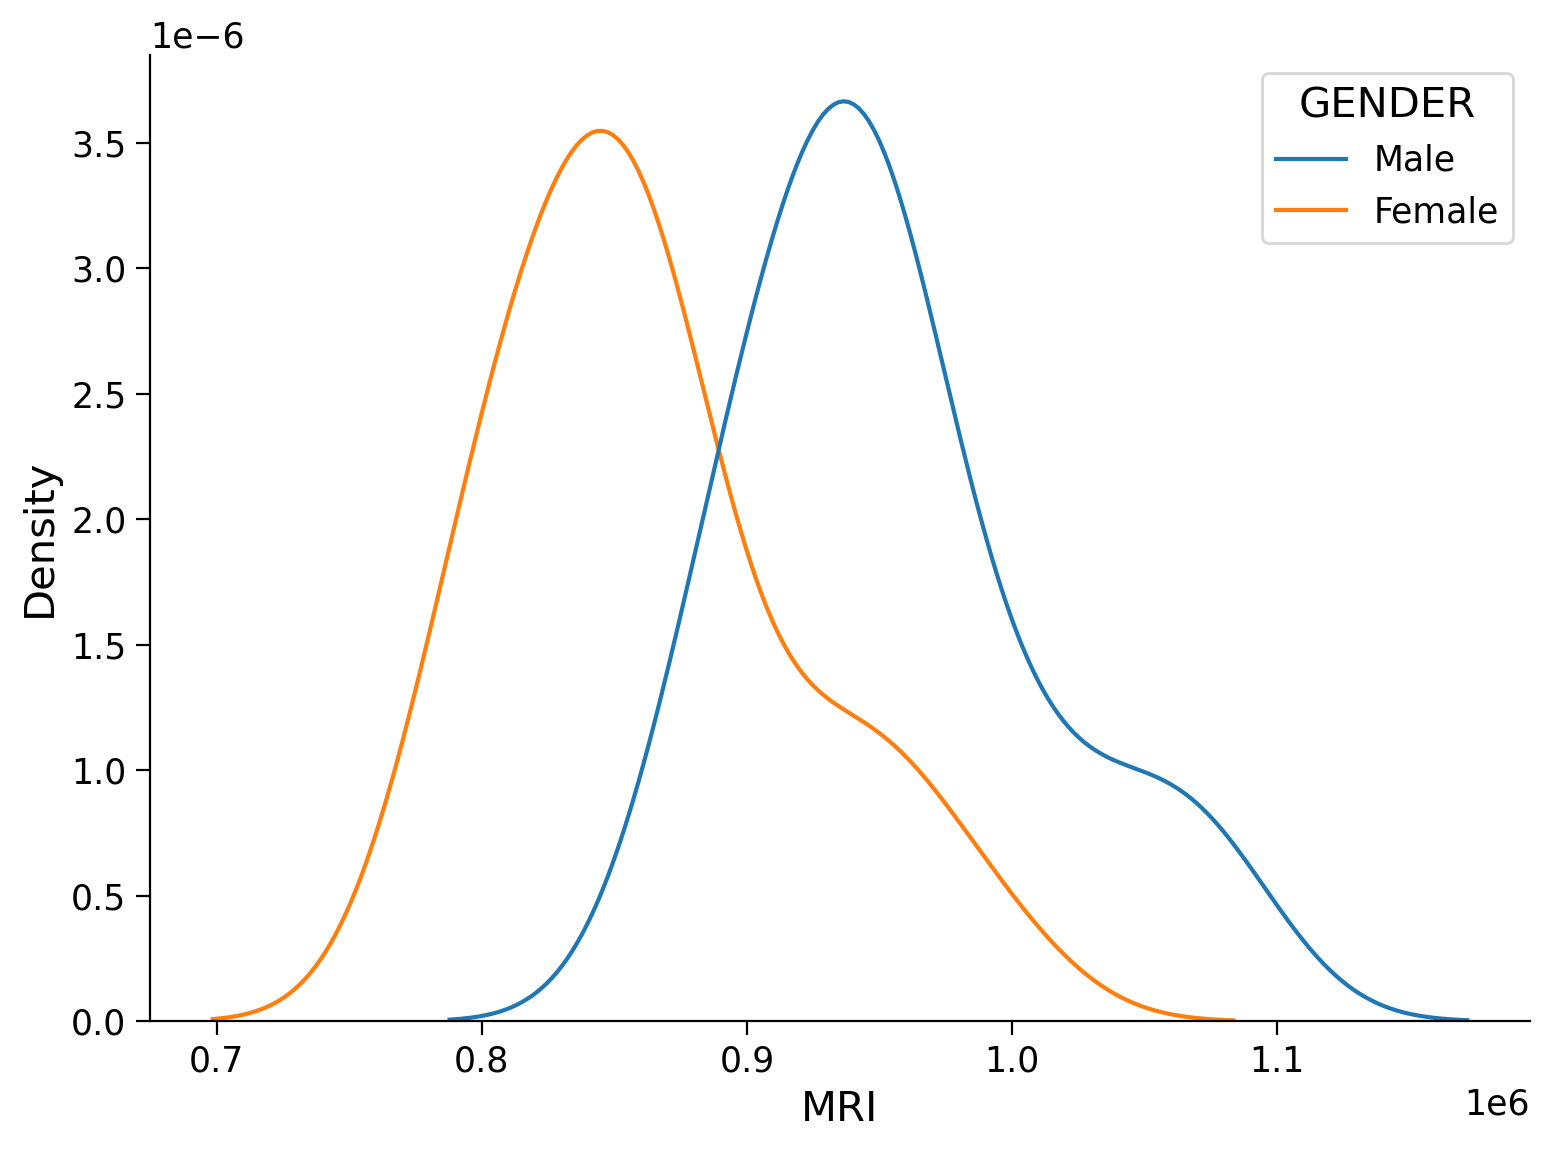

In [6]:
sns.kdeplot(data=brain_data, x="MRI", hue="GENDER");

Usando PyMC e un modello di regressione, si stabilisca (a) se c'è una differenza credibile nella grandezza del cervello tra maschi e femmine (b) se c'è una differenza credibile nel FSQI tra maschi e femmine. (c) Si interpretino i risultati.

Si standardizzimo i dati prima di effettuare l'analisi di regressione.

## Soluzione

Standardizziamo i dati MRI e codifichiamo il genere come una variabile dicotomica.

In [8]:
brain_data['mri'] = (brain_data['MRI'] - brain_data['MRI'].mean()) / brain_data['MRI'].std()
brain_data['gender'] = (brain_data['GENDER'] == 'Male').astype(int)

In [11]:
data_list = {
    'N': len(brain_data['mri']),
    'x': brain_data['gender'].values,
    'y': brain_data['mri'].values
}

df = pd.DataFrame(data_list)
df.head()

,N,x,y
0,40,1,1.277855
1,40,1,1.794111
2,40,1,0.783016
3,40,1,-0.053914
4,40,1,0.646232


In [12]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', 0, 2.5)
    beta = pm.Normal('beta', 0, 2.5)
    sigma = pm.HalfNormal('sigma', 10)
    mu = alpha + beta * df['x']
    y_obs = pm.Normal('y_obs', mu, sigma, observed=df['y'])

In [13]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Esaminiamo i risultati del campionamento MCMC:

In [14]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.62,0.18,-0.96,-0.28,0.00,0.0,1904.02,2296.82,1.0
beta,1.25,0.26,0.76,1.73,0.01,0.0,1896.22,2291.88,1.0
sigma,0.80,0.10,0.63,0.98,0.00,0.0,2285.76,1975.80,1.0


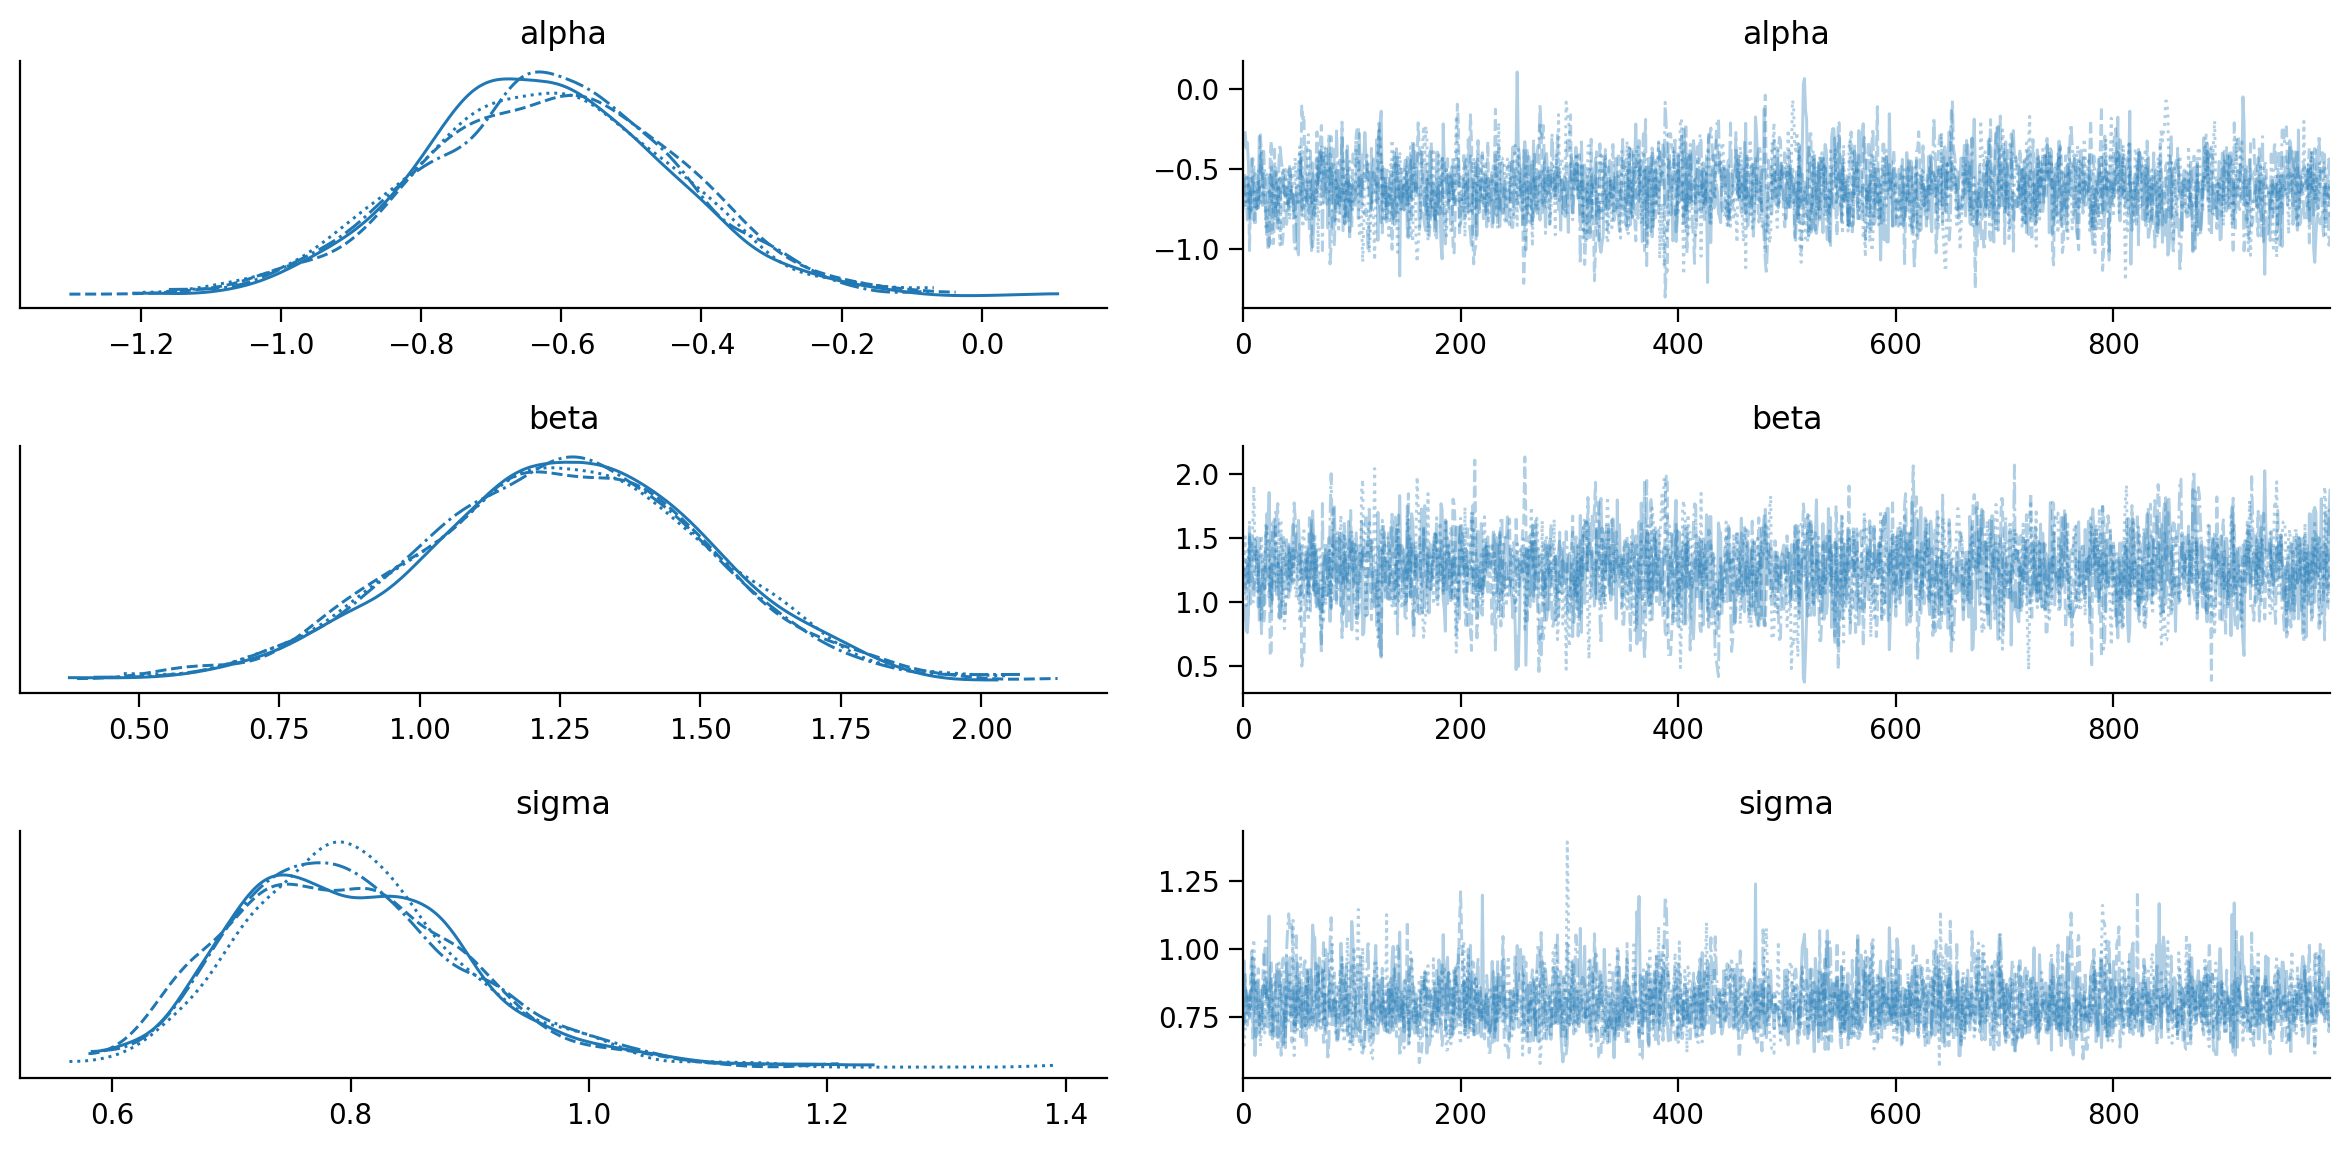

In [15]:
# Diagnostica
az.plot_trace(idata);

In [17]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    alpha    (hdi) float64 -0.9827 -0.2663
    beta     (hdi) float64 0.7593 1.773
    sigma    (hdi) float64 0.632 1.001

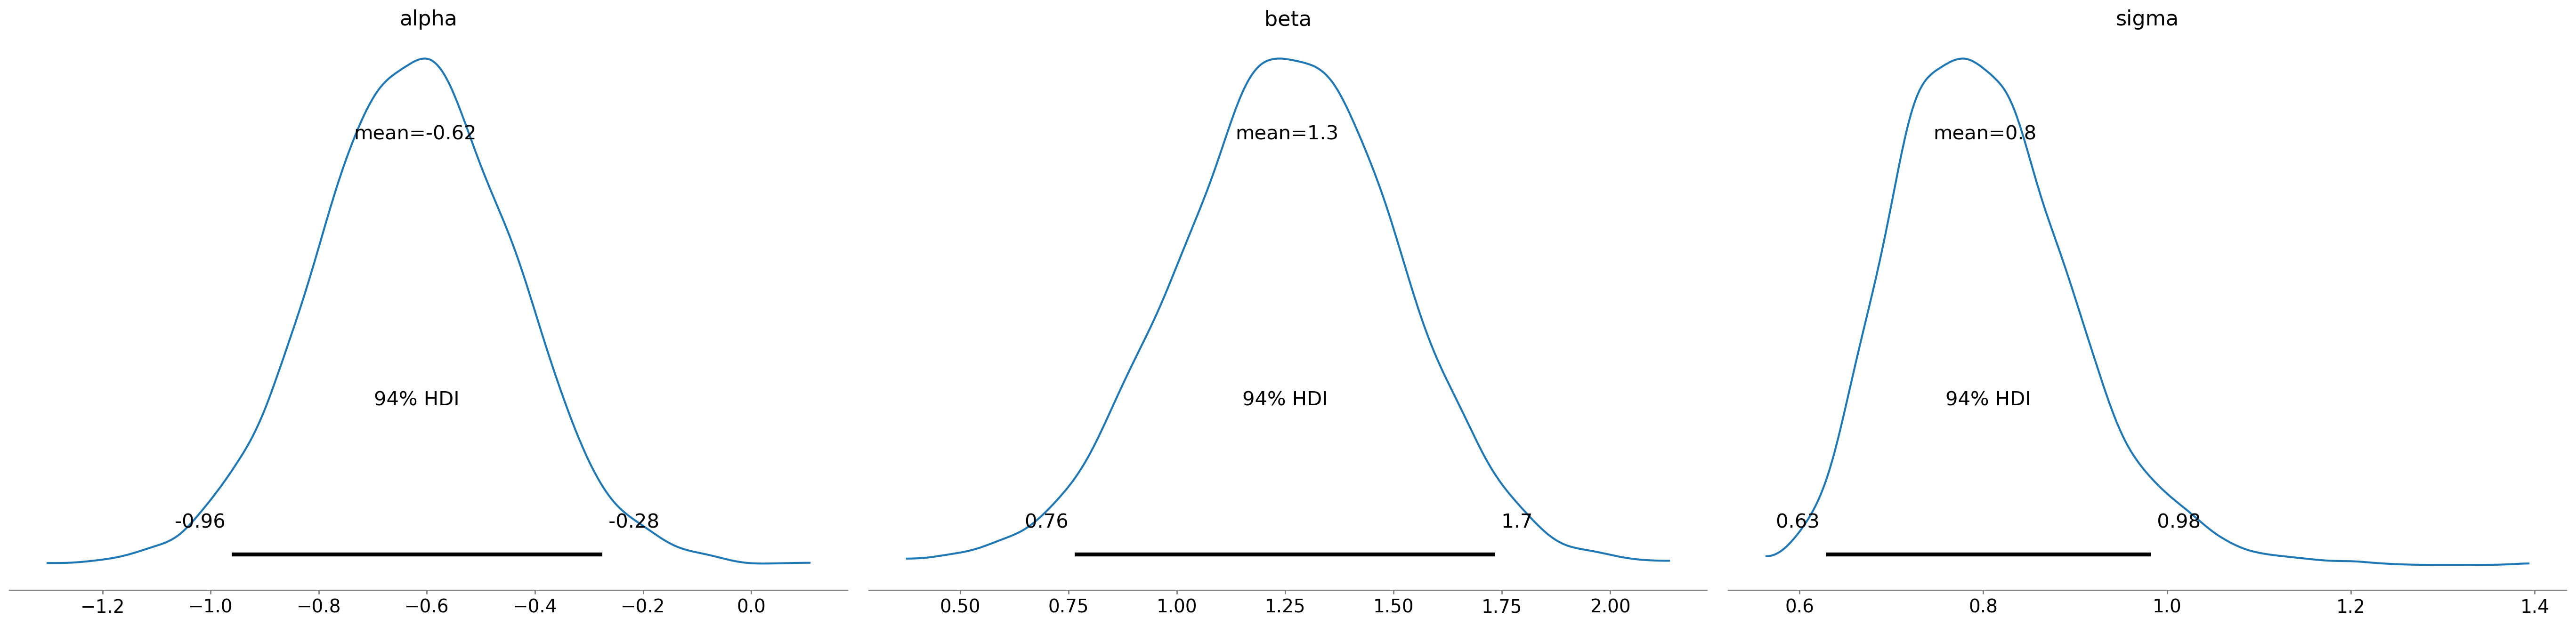

In [19]:
az.plot_posterior(idata, round_to=2);

Il parametro di interesse è $\beta$. Ci dice che, quando passiamo dalla distribuzione a posteriori delle femmine a quella dei maschi (da 0 a 1 nella variabile genere), la grandezza del cervello aumenta in media di 1.25 deviazioni standard, 95% CI [0.75, 1.75].

## Analisi del FSIQ

Ora analizziamo le differenze nel FSIQ tra maschi e femmine usando lo stesso modello.

In [21]:
data_list2 = {
    'N': len(brain_data['gender']),
    'x': brain_data['gender'].values,
    'y': (brain_data['FSIQ'] - brain_data['FSIQ'].mean()) / brain_data['FSIQ'].std()
}

df2 = pd.DataFrame(data_list2)
df2.head()

,N,x,y
0,40,1,1.102480
1,40,1,1.060955
2,40,1,0.811807
3,40,1,-1.015278
4,40,1,0.811807


In [22]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', 0, 2.5)
    beta = pm.Normal('beta', 0, 2.5)
    sigma = pm.HalfNormal('sigma', 10)
    mu = alpha + beta * df2['x']
    y_obs = pm.Normal('y_obs', mu, sigma, observed=df2['y'])

In [25]:
with model:
    idata2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


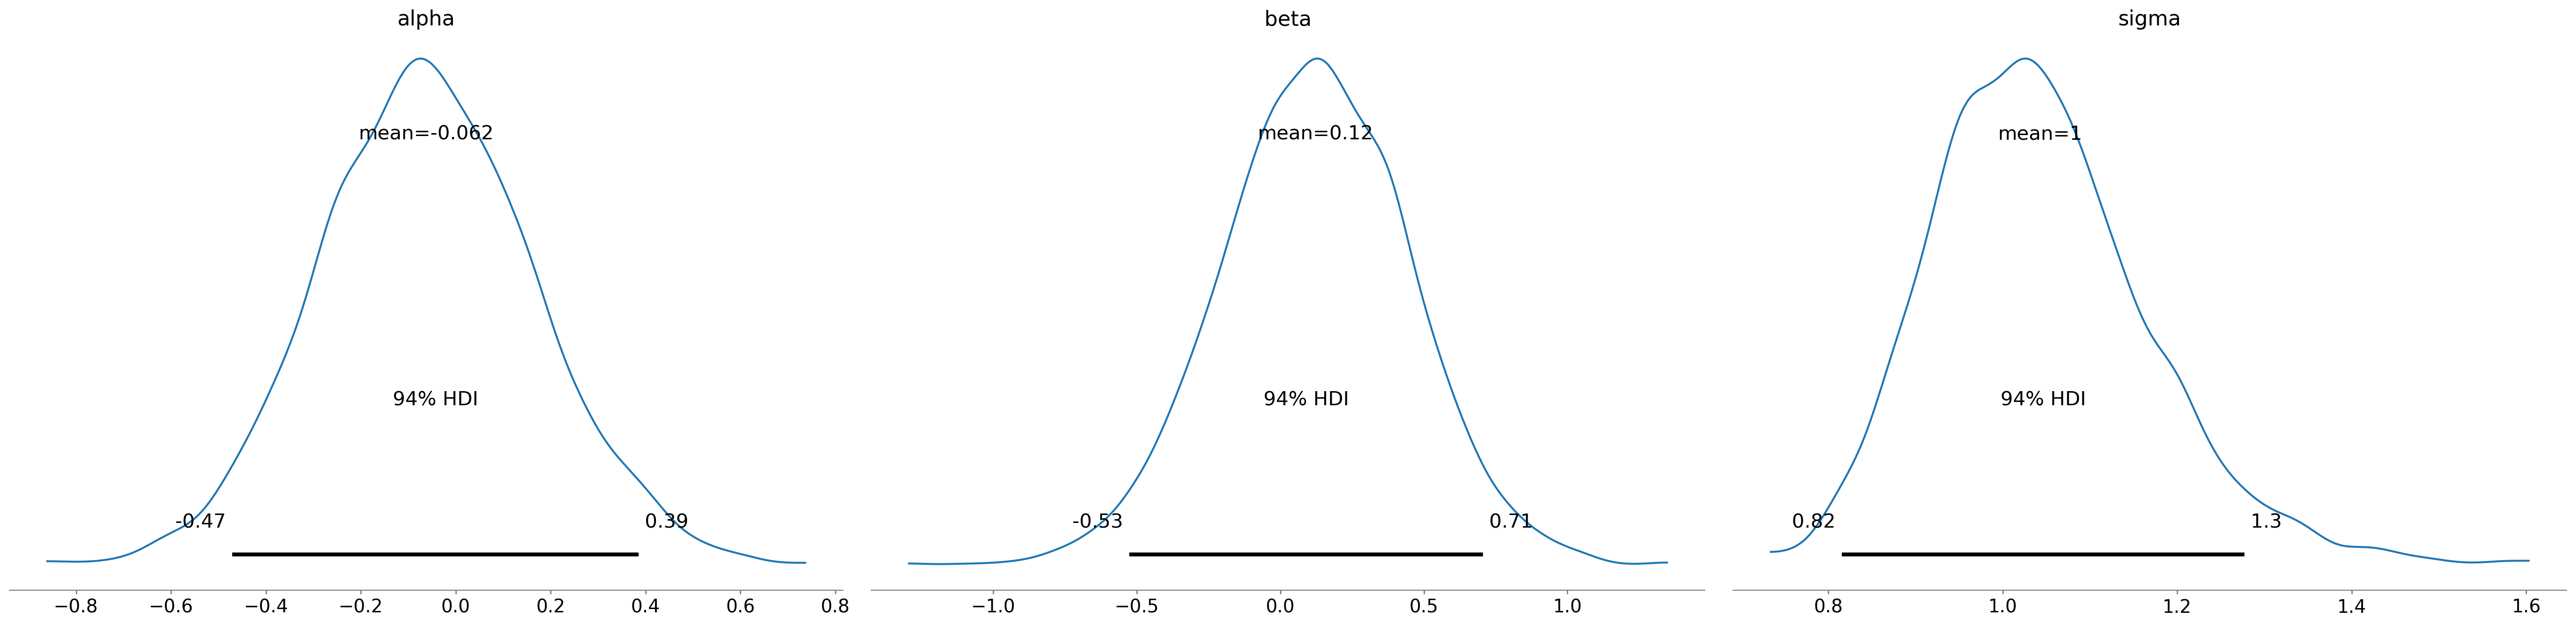

In [26]:
# Grafico della distribuzione a posteriori dei parametri
az.plot_posterior(idata2, round_to=2);

In [27]:
az.summary(idata2, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.06,0.23,-0.47,0.39,0.01,0.00,1971.87,2588.24,1.0
beta,0.12,0.33,-0.53,0.71,0.01,0.01,1861.63,2290.36,1.0
sigma,1.04,0.12,0.82,1.28,0.00,0.00,2405.88,2471.94,1.0


La distribuzione a posteriori di $\beta$ indica come l'intervallo di credibilità al 94% include il valore 0.  Non vi è dunque alcuna evidenza di differenze nel FSIQ tra maschi e femmine.

## Conclusioni

La letteratura che descrive lo studio dell'intelligenza ha conciliato questi risultati apparentemente contraddittori (vi è un'associazione positiva tra grandezza del cervello e IQ; la grandezza del cervello è maggiore per i maschi rispetto alle femmine; non c'è evidenza di differenza nel QI in funzione del genere) nel modo seguente. Anche se il cervello delle femmine, in media, è più piccolo di quello dei maschi, *l'efficienza* delle computazioni neurali delle femmine è maggiore di quella dei maschi.
